In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

torch.__version__

/home/firiuza/anaconda2/envs/pytorch_env2/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.6.0+cu101'

In [2]:
torch.version.cuda

'10.1'

In [3]:
import numpy as np
import random
import time
import zipfile
import os

from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## ETL

In [4]:
%%time 

train = zipfile.ZipFile('/home/firiuza/PycharmProjects/HSE_WINTER_2021_2022/week10/train.zip')
train.extractall('.')

CPU times: user 8.3 s, sys: 3.94 s, total: 12.2 s
Wall time: 12.6 s


In [5]:
%%time

test = zipfile.ZipFile('/home/firiuza/PycharmProjects/HSE_WINTER_2021_2022/week10/val_kaggle.zip')
test.extractall('.')

CPU times: user 885 ms, sys: 387 ms, total: 1.27 s
Wall time: 1.3 s


In [6]:
train_dataset = torchvision.datasets.ImageFolder('train/' + 'train')

In [7]:
class_names = train_dataset.classes

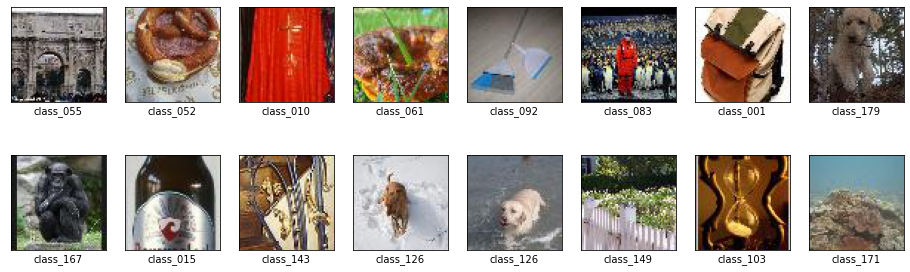

In [8]:
# отрисуем все что у нас есть
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_dataset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_dataset[random_index][0])
        ax.set_xlabel(class_names[train_dataset[random_index][1]])
plt.show()

In [9]:
# Смотрим что у нас там по девайсам
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

In [10]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [11]:
mean1 = torch.tensor([0.4802, 0.4481, 0.3975]) 
std1 = torch.tensor([0.2770, 0.2691, 0.2821])

In [12]:
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

TRAIN_PATH = "./train/train"
bs = 256
WEIGHT_DECAY = 0.0005
STEP_SIZE = 1000
LR_GAMMA = 0.99

train_tfms = transforms.Compose([ 
            transforms.ToTensor() 
           # don't use transforms.Normalize() for the first time
        ])
train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=64)

In [13]:
batch_size = bs # Выбираем размер батча
transform = torchvision.transforms.Compose([ # что нам делать по шагам в даталоудере
    torchvision.transforms.ToTensor(), # Пока просто переводим в тензор
    transforms.Normalize(mean1, std1) # Возможно стоит сделать что-то еще?
])

train_dataset = torchvision.datasets.ImageFolder('train/' + 'train', transform) # загрузили данные трейн
 
train_size = int(0.75 * len(train_dataset)) 
test_size = len(train_dataset) - train_size 
trainloader, valloader = torch.utils.data.random_split(train_dataset, [train_size, test_size]) 
 
trainloader = torch.utils.data.DataLoader(trainloader, 
                                          batch_size=batch_size, 
                                          shuffle=True, num_workers=64) 
valloader = torch.utils.data.DataLoader(valloader,  
                                          batch_size=batch_size, 
                                       shuffle=False, num_workers=64)

## Model

In [14]:
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels=3,
                                                  out_channels=16,
                                                  kernel_size=(3,3)),
                                        nn.BatchNorm2d(16),
                                        nn.LeakyReLU(),
                                        
                                        nn.Conv2d(in_channels=16,
                                                 out_channels=32,
                                                 kernel_size=(3,3)), 
                                        nn.BatchNorm2d(32),
                                        nn.LeakyReLU(),
                                        
                                        nn.Conv2d(in_channels=32,
                                                 out_channels=64,
                                                 kernel_size=(5,5)), 
                                        nn.BatchNorm2d(64),
                                        nn.LeakyReLU(),
                                        
                                        nn.Conv2d(in_channels=64,
                                                 out_channels=128,
                                                 kernel_size=(7,7)), 
                                        nn.BatchNorm2d(128),
                                        nn.LeakyReLU(),
                                        
                                        nn.Conv2d(in_channels=128,
                                                 out_channels=256,
                                                 kernel_size=(16,16)), 
                                        nn.BatchNorm2d(256),
                                        nn.LeakyReLU()
                                    )
        
        self.fc = nn.Linear(256, 200)
        

    def forward(self, x):
        feature_maps = self.conv_layers(x)
        
        global_avg_pool = torch.mean(feature_maps, [2, 3]) # batch_size X channels X width X height => bacth_size X channels
        
        logits = self.fc(global_avg_pool)
        
        probs = F.softmax(logits, dim=1)
        
        return logits, probs

## Training

In [15]:
from copy import deepcopy
class Main_train_loop():
    def __init__(self, batch_size, trainloader, testloader, Device, model, logs_base_dir='./'): 
        self.set_up_rnd_seed()
        
        self.batch_size = batch_size
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = Device
        self.model = model
        self.loss_arr = []
        self.loss_arr_test = []
        self.metric_train = []
        self.metric_test = []
        
        self.get_part_train_loop()
        
        self.train_summary_writer = SummaryWriter(logs_base_dir + 'train')
        self.valid_summary_writer = SummaryWriter(logs_base_dir + 'valid')
        
        return
        
        
    def get_part_train_loop(self):
        self.loss_fn = nn.CrossEntropyLoss()
        self.opt = optim.Adam(self.model.parameters(), lr=3e-4, weight_decay=WEIGHT_DECAY)
        self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt,
                                                            step_size=STEP_SIZE, 
                                                            gamma=LR_GAMMA)
        
        return
        

    def set_up_rnd_seed(self, seed=555):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

        return
    
    
    def save_model_params(self, models_base_dir):
        print('Save model')
        if not os.path.exists(models_base_dir):
            os.makedirs(models_base_dir)
        
        torch.save({
            'model': self.model.state_dict(),
            'optimizer': self.opt.state_dict(),
            'lr_scheduler': self.lr_scheduler.state_dict(),
            'step': self.step
        }, os.path.join(models_base_dir, 'model_state_dict_%d' % self.step))
        
        return
    
    def load_model_params(self, device, restore_model_path=''):
        if restore_model_path != '':
            checkpoint = torch.load(restore_model_path, map_location=device)
            
            self.model.load_state_dict(checkpoint['model'])
            self.opt.load_state_dict(checkpoint['optimizer'])
            self.lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])

#             self.opt.param_groups[0]['lr'] = 1e-3
#             self.lr_scheduler.optimizer = optimizer

            self.step = checkpoint['step']

            print('Model restored ...')
        else:
            self.step = 0

        return model

    def get_lr(self):
        for param_group in self.opt.param_groups:
            return param_group['lr']

        return
    
    def l2_norm(self, params, device):
        l2_reg = torch.tensor(0.).to(device)
        for param in params:
            l2_reg += torch.norm(param)

        return l2_reg

    
    def accurancy(self,y_predicts,data_y):
#         self.y_predicts = y_predicts
#         self.data_y = data_y
#         acc = (y_predicts == data_y).sum().item() / y_predicts.size(0)
        
        acc = f1_score(data_y, y_predicts, average='micro') #data_y.cpu().numpy()
        
        return acc

    
    def train_nn(self, trainloader, model, device):
        running_loss = []
        model.train()
        acc_list = []
        for i, data in tqdm(enumerate(trainloader, 0)):
            inputs, labels = data # Взятие данных
            inputs = inputs.to(device) # положили данные на GPU
            labels = labels.to(device) # положили данные на GPU

            self.opt.zero_grad() # очистили градиент
            outputs,probs = model(inputs)# Считаем прогноз
            y_pred = outputs.argmax(dim=1) # Посчитали прогнозы
            loss = self.loss_fn(outputs, labels) # посчитали лосс
            loss.backward() # посчитали градиенты
            
            reg_loss = WEIGHT_DECAY * self.l2_norm(model.parameters(), device)
            
            self.opt.step() # сделали шаг градиентного спуска
            self.lr_scheduler.step() # делаем шаг, чтобы понимать, когда обновлять learning rate

            running_loss.append(loss.item()) # разное всякое (метрики, лоссы)
            acc = self.accurancy(y_pred.cpu().numpy(), labels.cpu().numpy())
            acc_list.append(acc)

            self.train_summary_writer.add_scalar('CELoss', loss.item(), i)
            self.train_summary_writer.add_scalar('RegLoss', reg_loss.item(), i)
            self.train_summary_writer.add_scalar('Accuracy', acc, i)
            self.train_summary_writer.add_scalar('LearningRate', self.get_lr(), i)
            
            self.step += 1

        return model, running_loss,acc_list


    def eval_nn(self, testloader, model, loss_fn, device, epoch):
        running_loss_test = []
        acc_list = []

        model.eval()
        all_predicts = []
        all_labels = []
        with torch.no_grad():
            for i, data in enumerate(testloader):
                inputs, labels = data
                inputs = inputs.to(device)

                outputs,proba = model(inputs)
                y_pred = outputs.cpu().argmax(dim=1)
                all_predicts.extend(y_pred)
                all_labels.extend(labels)
                
                loss = loss_fn(outputs.cpu(), labels)

                running_loss_test.append(loss.item())
            
            acc_value = self.accurancy(all_labels, all_predicts)
            
            self.valid_summary_writer.add_scalar('CELoss', np.mean(running_loss_test), epoch)
            self.valid_summary_writer.add_scalar('Accuracy', acc_value, epoch)
                
        return np.mean(running_loss_test), acc_value

    
    def training_loop(self, max_epochs=20):
        self.load_model_params(self.device, restore_model_path='')
        
        for epoch in range(max_epochs):
            start_time = time.time()
            self.model, running_loss,acc_train = self.train_nn(self.trainloader, 
                                                             self.model, self.device)
            running_loss_test, acc_eval = self.eval_nn(self.testloader, 
                                                       self.model, self.loss_fn, 
                                                       self.device, epoch)

            self.loss_arr.append(np.mean(running_loss))
            self.loss_arr_test.append(running_loss_test)


            self.metric_train.append(np.mean(acc_train))
            self.metric_test.append(acc_eval)
            if np.mean(acc_eval) >= np.max(self.metric_test):
                self.best_model = deepcopy(self.model)
                self.best_epoch = epoch

            
            duration = time.time() - start_time
            print(f"""EPOCH {epoch} : train_loss: {self.metric_train[-1]:.5f} 
            test_loss: {self.metric_test[-1]:.5f}.
            Заняло времени {round(duration,2)} секунд""")
            
            print('Save model')
            self.save_model_params('./models')

In [16]:
model = CNN() # инициализировали модель
model.to(DEVICE) # положили на gpu
main_loop = Main_train_loop(batch_size, trainloader, valloader, DEVICE, model) # инициализировали обучающий класс

In [17]:
main_loop.training_loop(20)

12it [01:16,  6.36s/it]


KeyboardInterrupt: 

## Transfer Learning

In [19]:
import torchvision.models as models 
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        resnet18 = models.resnet18(pretrained=True)
        
        self.backbone = nn.Sequential(*(list(resnet18.children())[:-1]))
        self.freeze_layers(self.backbone)
        
        self.fc = nn.Linear(512, 200)
    
    
    def freeze_layers(self, model):
        for param in model.parameters(): 
            param.requires_grad = False
            
        return 
        

    def forward(self, x):
        avg_pool = self.backbone(x)
        
        avg_pool = torch.squeeze(avg_pool, 2)
        avg_pool = torch.squeeze(avg_pool, 2)
        
        logits = self.fc(avg_pool)
        
        probs = F.softmax(logits, dim=1)
        
        return logits, probs

In [20]:
model = CNN() # инициализировали модель
model.to(DEVICE) # положили на gpu
main_loop = Main_train_loop(batch_size, trainloader, valloader, DEVICE, model) # инициализировали обучающий класс
main_loop.get_part_train_loop()
main_loop.training_loop(20)

293it [00:12, 23.29it/s]


EPOCH 0 : train_loss: 0.14544 
            test_loss: 0.25397.
            Заняло времени 23.79 секунд
Save model


293it [00:12, 22.65it/s]


EPOCH 1 : train_loss: 0.29796 
            test_loss: 0.30368.
            Заняло времени 24.54 секунд
Save model


293it [00:12, 23.38it/s]


EPOCH 2 : train_loss: 0.34008 
            test_loss: 0.31812.
            Заняло времени 23.62 секунд
Save model


293it [00:12, 22.90it/s]


EPOCH 3 : train_loss: 0.36188 
            test_loss: 0.33083.
            Заняло времени 23.87 секунд
Save model


293it [00:12, 23.34it/s]


EPOCH 4 : train_loss: 0.37830 
            test_loss: 0.33889.
            Заняло времени 23.86 секунд
Save model


293it [00:12, 23.33it/s]


EPOCH 5 : train_loss: 0.38803 
            test_loss: 0.33943.
            Заняло времени 23.81 секунд
Save model


293it [00:12, 23.21it/s]


EPOCH 6 : train_loss: 0.39739 
            test_loss: 0.34329.
            Заняло времени 23.72 секунд
Save model


293it [00:12, 22.91it/s]


EPOCH 7 : train_loss: 0.40659 
            test_loss: 0.34558.
            Заняло времени 23.79 секунд
Save model


293it [00:12, 23.16it/s]


EPOCH 8 : train_loss: 0.41160 
            test_loss: 0.34630.
            Заняло времени 23.59 секунд
Save model


293it [00:12, 22.92it/s]


EPOCH 9 : train_loss: 0.41677 
            test_loss: 0.34433.
            Заняло времени 24.03 секунд
Save model


293it [00:14, 20.13it/s]


EPOCH 10 : train_loss: 0.42305 
            test_loss: 0.34758.
            Заняло времени 27.49 секунд
Save model


293it [00:14, 20.21it/s]


EPOCH 11 : train_loss: 0.42741 
            test_loss: 0.34855.
            Заняло времени 26.81 секунд
Save model


293it [00:14, 20.90it/s]


EPOCH 12 : train_loss: 0.43012 
            test_loss: 0.34764.
            Заняло времени 26.44 секунд
Save model


293it [00:16, 17.91it/s]


EPOCH 13 : train_loss: 0.43369 
            test_loss: 0.34777.
            Заняло времени 30.54 секунд
Save model


293it [00:18, 15.63it/s]


EPOCH 14 : train_loss: 0.43760 
            test_loss: 0.34594.
            Заняло времени 33.7 секунд
Save model


293it [00:17, 16.85it/s]


EPOCH 15 : train_loss: 0.43942 
            test_loss: 0.34452.
            Заняло времени 32.51 секунд
Save model


293it [00:13, 21.61it/s]


EPOCH 16 : train_loss: 0.44284 
            test_loss: 0.35008.
            Заняло времени 25.44 секунд
Save model


293it [00:12, 22.75it/s]


EPOCH 17 : train_loss: 0.44484 
            test_loss: 0.34735.
            Заняло времени 24.18 секунд
Save model


293it [00:12, 22.90it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/firiuza/anaconda2/envs/pytorch_env2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-5909ed6f8c4a>", line 5, in <module>
    main_loop.training_loop(20)
  File "<ipython-input-15-0073a0933903>", line 80, in training_loop
    self.loss_fn, self.device)
  File "<ipython-input-15-0073a0933903>", line 57, in eval_nn
    for i, data in enumerate(testloader):
  File "/home/firiuza/anaconda2/envs/pytorch_env2/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 291, in __iter__
    return _MultiProcessingDataLoaderIter(self)
  File "/home/firiuza/anaconda2/envs/pytorch_env2/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 764, in __init__
    self._try_put_index()
  File "/home/firiuza/anaconda2/envs/pytorch_env2/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1005, in _try_put_inde

TypeError: object of type 'NoneType' has no len()